# Loading the Data

In [36]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import shap
import cfbd
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


In [5]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [6]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [7]:
plays = (
    plays
    .assign(play_text=plays.play_text.fillna('')
            .str.replace(',', '', regex=False)
            .str.replace('.', '', regex=False)
            .str.lower())
    .assign(play_text=lambda x: ' ' + x.play_text + ' ')
    .query('down.isin([1, 2, 3]) and period.isin([1, 2, 3, 4])')
    .reset_index(drop=True)
)

sure_run_plays = [
    'Rush', 'Rushing Touchdown'
]
potential_run_plays = [
    'Safety', 'Fumble Recovery (Own)', 'Fumble Return Touchdown', 
    'Fumble Recovery (Opponent)', 'Uncategorized', 'placeholder'
]
run_condition = (
    plays['play_type'].isin(sure_run_plays) |
    (
        plays['play_type'].isin(potential_run_plays) &
        ~plays['play_text'].str.contains(" pass ") &
        ~plays['play_text'].str.contains(" sacked ") &
        ~plays['play_text'].str.contains(" sack ") &
        ~plays['play_text'].str.contains(" interception ") &
        ~plays['play_text'].str.contains(" intercepted ") &
        ~plays['play_text'].str.contains(" kneel ") &
        ~plays['play_text'].str.contains(" kneeling ") &
        ~plays['play_text'].str.contains(" kneels ") &
        (
            plays['play_text'].str.contains(" run ") |
            plays['play_text'].str.contains(" rush ") |
            plays['play_text'].str.contains(" rushing ") |
            plays['play_text'].str.contains(" rushed ")
        )
    )
)

sure_pass_plays = [
    'Pass Completion', 'Pass Incompletion', 'Pass Interception', 'Sack', 'Pass',
    'Passing Touchdown', 'Pass Reception', 'Pass Interception Return', 
    'Interception Return Touchdown', 'Interception',
]
potential_pass_plays = [
    'Safety', 'Fumble Recovery (Own)', 'Fumble Return Touchdown', 
    'Fumble Recovery (Opponent)', 'Uncategorized', 'placeholder'
]
pass_condition = (
    plays['play_type'].isin(sure_pass_plays) |
    (
        plays['play_type'].isin(potential_pass_plays) &
        ~plays['play_text'].str.contains(" run ") &
        ~plays['play_text'].str.contains(" rush ") &
        ~plays['play_text'].str.contains(" kneel ") &
        ~plays['play_text'].str.contains(" kneeling ") &
        ~plays['play_text'].str.contains(" kneels ") &
        (        
            plays['play_text'].str.contains(" pass ") |
            plays['play_text'].str.contains(" sack ") |
            plays['play_text'].str.contains(" sacked ") |
            plays['play_text'].str.contains(" intercepted ") |
            plays['play_text'].str.contains(" interception ") |
            plays['play_text'].str.contains(" intentional grounding ") |
            plays['play_text'].str.contains(" scramble ") 
        )
    )
)

field_goal_condition = (
    plays['play_type'].str.contains('Field Goal') |
    plays['play_text'].str.contains(" field goal ") |
    plays['play_text'].str.contains(" fg ")
)

kneel_condition = (
    plays['play_text'].str.contains(" kneel ") |
    plays['play_text'].str.contains(" kneeling ") |
    plays['play_text'].str.contains(" kneels ")
)

plays['play_decision'] = np.select(
    [kneel_condition, field_goal_condition, run_condition, pass_condition],
    ['kneel', 'field_goal', 'run', 'pass'],
    default='other'
)

drop_play_types = ['Penalty', 'Timeout',
       'Kickoff', 'Kickoff Return Touchdown',
       'Kickoff Return (Offense)', #'Uncategorized',
       'Defensive 2pt Conversion',
       'Punt Return Touchdown', 'Blocked Punt', #'placeholder',
       'End Period', 'End of Half', 'End of Regulation',
       'End of Game', 'Blocked Punt Touchdown', 'Punt'
]
plays = plays.query('play_type not in @drop_play_types and play_decision != "other"').reset_index(drop=True)

In [8]:
plays.play_decision.value_counts()

play_decision
run           824501
pass          768684
kneel           2516
field_goal      2272
Name: count, dtype: int64

In [34]:
cols = ['offense_timeouts', 'defense_timeouts', 'yards_to_goal', 'down', 'distance',
    'score_diff', 'seconds_remaining', 'pct_game_played', 'diff_time_ratio', 'play_decision']
decisions = (
    plays
    .assign(
        offense_timeouts = lambda x: np.where(x.offense_timeouts == -1, 0, x.offense_timeouts),
        defense_timeouts = lambda x: np.where(x.defense_timeouts == -1, 0, x.defense_timeouts)
    )
    .query('0 < yards_to_goal < 100 and 0 < distance < 100 and '
           '0 <= offense_timeouts <= 3 and 0 <= defense_timeouts <= 3 and '
           '0 <= clock_minutes <= 15 and 0 <= clock_seconds < 59')
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        seconds_remaining = lambda x: (
            (4 * 15 * 60) - # total game time in seconds
            ((x['period'] - 1) * 15 * 60) - # elapsed quarters in seconds
            (15 * 60 - (x['clock_minutes'] * 60 + x['clock_seconds'])) 
        )
    )
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
    )
    .assign(
        was_pass=lambda x: (x['play_decision'] == 'pass').astype(int),
        was_run=lambda x: (x['play_decision'] == 'run').astype(int),
        was_field_goal=lambda x: (x['play_decision'] == 'field_goal').astype(int),
        was_kneel=lambda x: (x['play_decision'] == 'kneel').astype(int)
    )
    [cols + ['was_pass', 'was_run', 'was_field_goal', 'was_kneel']]
)
decisions.head()

,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,score_diff,seconds_remaining,pct_game_played,diff_time_ratio,play_decision,was_pass,was_run,was_field_goal,was_kneel
0,0.0,2.0,72,3,10,-11,81,0.977500,-548.888472,pass,1,0,0,0
1,0.0,2.0,72,2,10,-11,91,0.974722,-542.823468,pass,1,0,0,0
2,0.0,2.0,72,1,10,-11,95,0.973611,-540.416272,pass,1,0,0,0
3,3.0,3.0,37,1,10,-7,2940,0.183333,-14.574064,run,0,1,0,0
4,3.0,3.0,51,2,6,-7,2965,0.176389,-14.174799,pass,1,0,0,0


In [40]:
feature_names = [
    'offense_timeouts', 
    'defense_timeouts', 
    'yards_to_goal', 
    'down',
    'distance', 
    'score_diff', 
    'seconds_remaining', 
    'pct_game_played',
    'diff_time_ratio', 
]

# Encode play_decision: pass -> 0, run -> 1, field_goal -> 2, kneel -> 3
decisions['play_decision'] = decisions['play_decision'].map({
    'pass': 0,
    'run': 1,
    'field_goal': 2,
    'kneel': 3
})

data = decisions[feature_names + ['play_decision']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['play_decision']
)
test_x, test_y = test_data[feature_names], test_data['play_decision']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data['play_decision'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['play_decision']
)

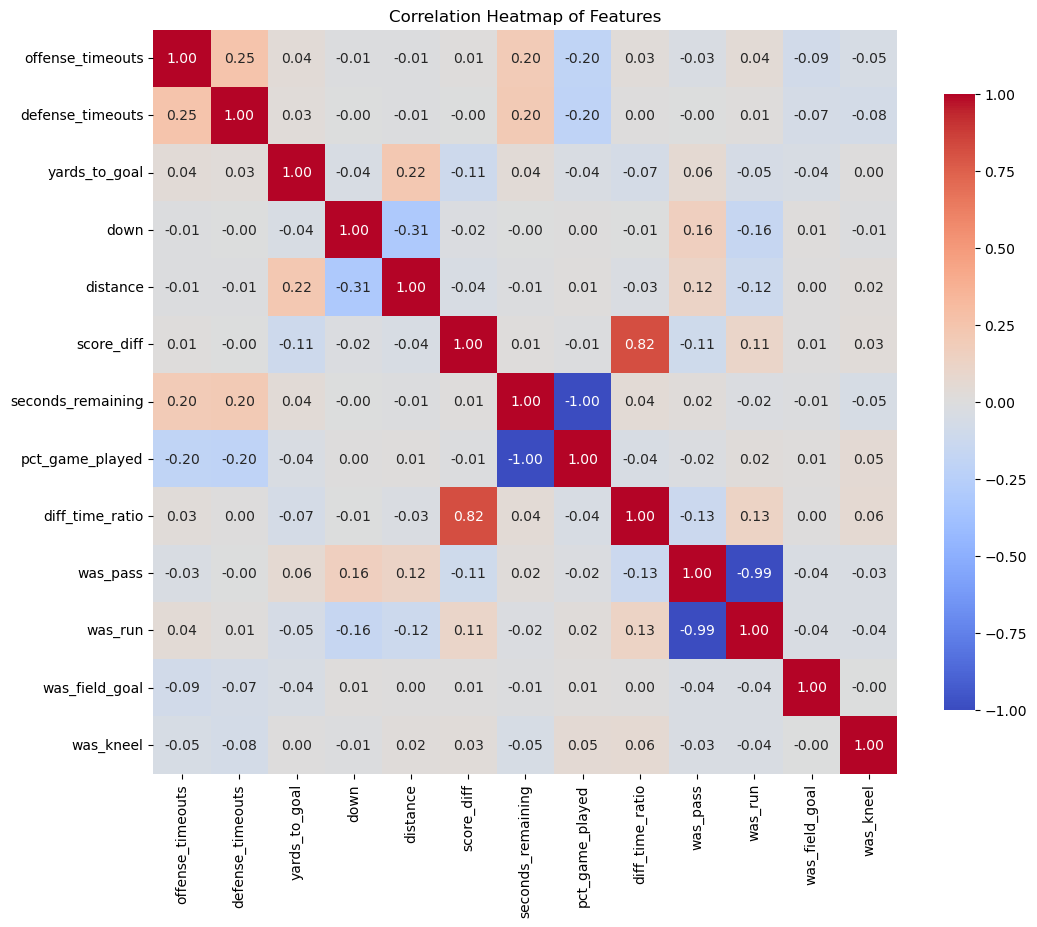

In [35]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    decisions[feature_names + ['was_pass', 'was_run', 'was_field_goal', 'was_kneel']].corr(),
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [42]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "multi:softprob",  # Changed for multiclass
        "num_class": 4,  # Added for multiclass
        "eval_metric": "mlogloss",  # Changed to multiclass logloss
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
    
    # Calculate multiclass log loss
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="multiclass_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(
    lambda trial: objective(trial, dtrain, dvalid), 
    n_trials=50,
    show_progress_bar=True
)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'multi:softprob',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'booster': 'gbtree',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

def evaluate_multiclass(y_true, y_pred):
    # Calculate various multiclass metrics
    y_pred_class = np.argmax(y_pred, axis=1)
    
    print(f"Multiclass log loss: {log_loss(y_true, y_pred):0.3f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred_class):0.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_class))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred_class))
    
    # Calculate ROC AUC if binary (for each class)
    if len(np.unique(y_true)) <= 2:
        print(f"\nROC AUC: {roc_auc_score(y_true, y_pred[:, 1]):0.3f}")
    else:
        try:
            print("\nROC AUC (OvR):")
            for i in range(4):  # For each class
                print(f"Class {i}: {roc_auc_score((y_true == i).astype(int), y_pred[:, i]):0.3f}")
            print(f"Macro average: {roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro'):0.3f}")
        except:
            print("Couldn't calculate ROC AUC for all classes")

# Evaluate on train set
print("\n=== Train Set ===")
train_preds = final_model.predict(dtrain)
evaluate_multiclass(train_y, train_preds)

# Evaluate on validation set
print("\n=== Validation Set ===")
valid_preds = final_model.predict(dvalid)
evaluate_multiclass(valid_y, valid_preds)

# Evaluate on test set
print("\n=== Test Set ===")
dtest = xgb.DMatrix(test_x, label=test_y)
test_preds = final_model.predict(dtest)
evaluate_multiclass(test_y, test_preds)

  0%|          | 0/50 [00:00<?, ?it/s]

Number of boosted rounds: 459

=== Train Set ===
Multiclass log loss: 0.602
Accuracy: 0.664

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.56      0.61    478633
           1       0.65      0.77      0.70    514311
           2       0.83      0.77      0.80      1359
           3       0.83      0.13      0.23      1285

    accuracy                           0.66    995588
   macro avg       0.75      0.56      0.59    995588
weighted avg       0.67      0.66      0.66    995588


Confusion Matrix:
[[265659 212843    131      0]
 [119582 394612     83     34]
 [   235     77   1047      0]
 [    25   1083      8    169]]

ROC AUC (OvR):
Class 0: 0.733
Class 1: 0.732
Class 2: 0.999
Class 3: 0.998
Macro average: 0.866

=== Validation Set ===
Multiclass log loss: 0.612
Accuracy: 0.658

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.55      0.61    119659
        

In [44]:
from sklearn.dummy import DummyClassifier

# Fit a dummy classifier that always predicts class probabilities
dummy = DummyClassifier(strategy="prior")
dummy.fit(train_x, train_y)  # train_y should be encoded (0, 1, 2, 3)

# Evaluate on test set
dummy_probs = dummy.predict_proba(test_x)
dummy_log_loss = log_loss(test_y, dummy_probs)
print(f"Dummy classifier log loss: {dummy_log_loss:0.3f}")

Dummy classifier log loss: 0.711


In [ ]:
n_row = 10000  # Reduced for memory safety
chunk_size = 5000  # Smaller chunks
background = train_data[feature_names].iloc[:n_row]

# Initialize explainer - critical fix for multiclass
explainer = shap.TreeExplainer(final_model, background, feature_perturbation="interventional")

# Process in chunks
shap_values_list = []
for i in tqdm(range(0, n_row, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_values_chunk = explainer.shap_values(chunk)
    shap_values_list.append(shap_values_chunk)

# Combine chunks - now returns list of arrays [class1, class2, class3, class4]
shap_values = [np.concatenate([sv[i] for sv in shap_values_list], axis=0) 
               for i in range(4)]  # For 4 classes

# Class names matching your encoding
class_names = ['Pass', 'Run', 'FG Attempt', 'QB Kneel']

# Plot each class
for class_idx in range(4):
    print(f"\n=== SHAP Summary for {class_names[class_idx]} ===")
    shap.summary_plot(
        shap_values[class_idx],  # SHAP values for this class
        background,
        plot_type="dot",
        max_display=15,
        show=False
    )
    plt.title(f"Feature Importance: {class_names[class_idx]}")
    plt.show()

  9%|==                  | 1726/20000 [01:41<17:49]       

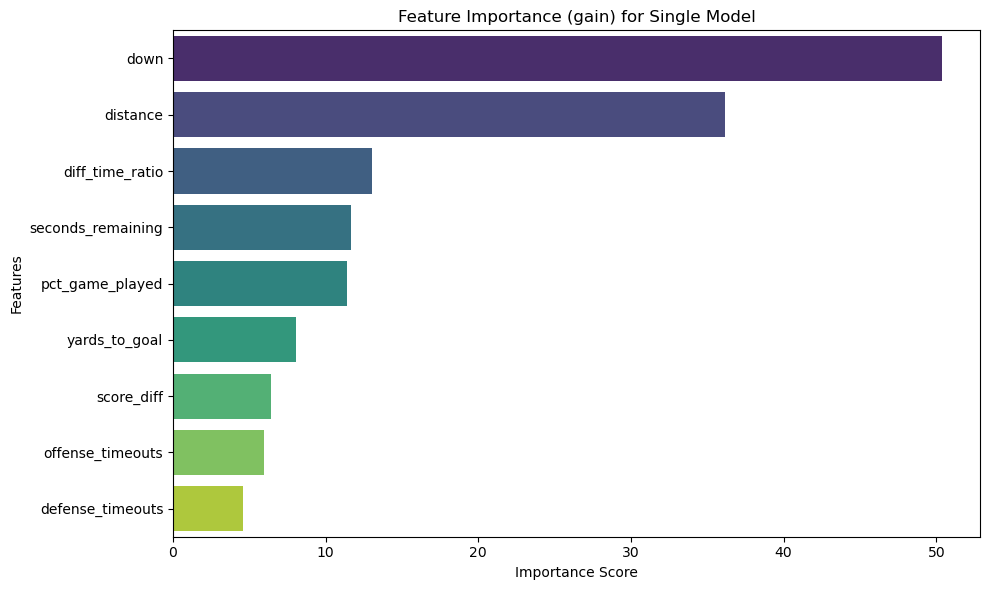

In [46]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [47]:
class_probas = final_model.predict(xgb.DMatrix(decisions[feature_names]))

decisions['pass_proba'] = class_probas[:, 0]  # Class 0: Pass
decisions['run_proba'] = class_probas[:, 1]    # Class 1: Run
decisions['fg_proba'] = class_probas[:, 2]     # Class 2: FG
decisions['qb_kneel_proba'] = class_probas[:, 3]  # Class 3: QB Kneel

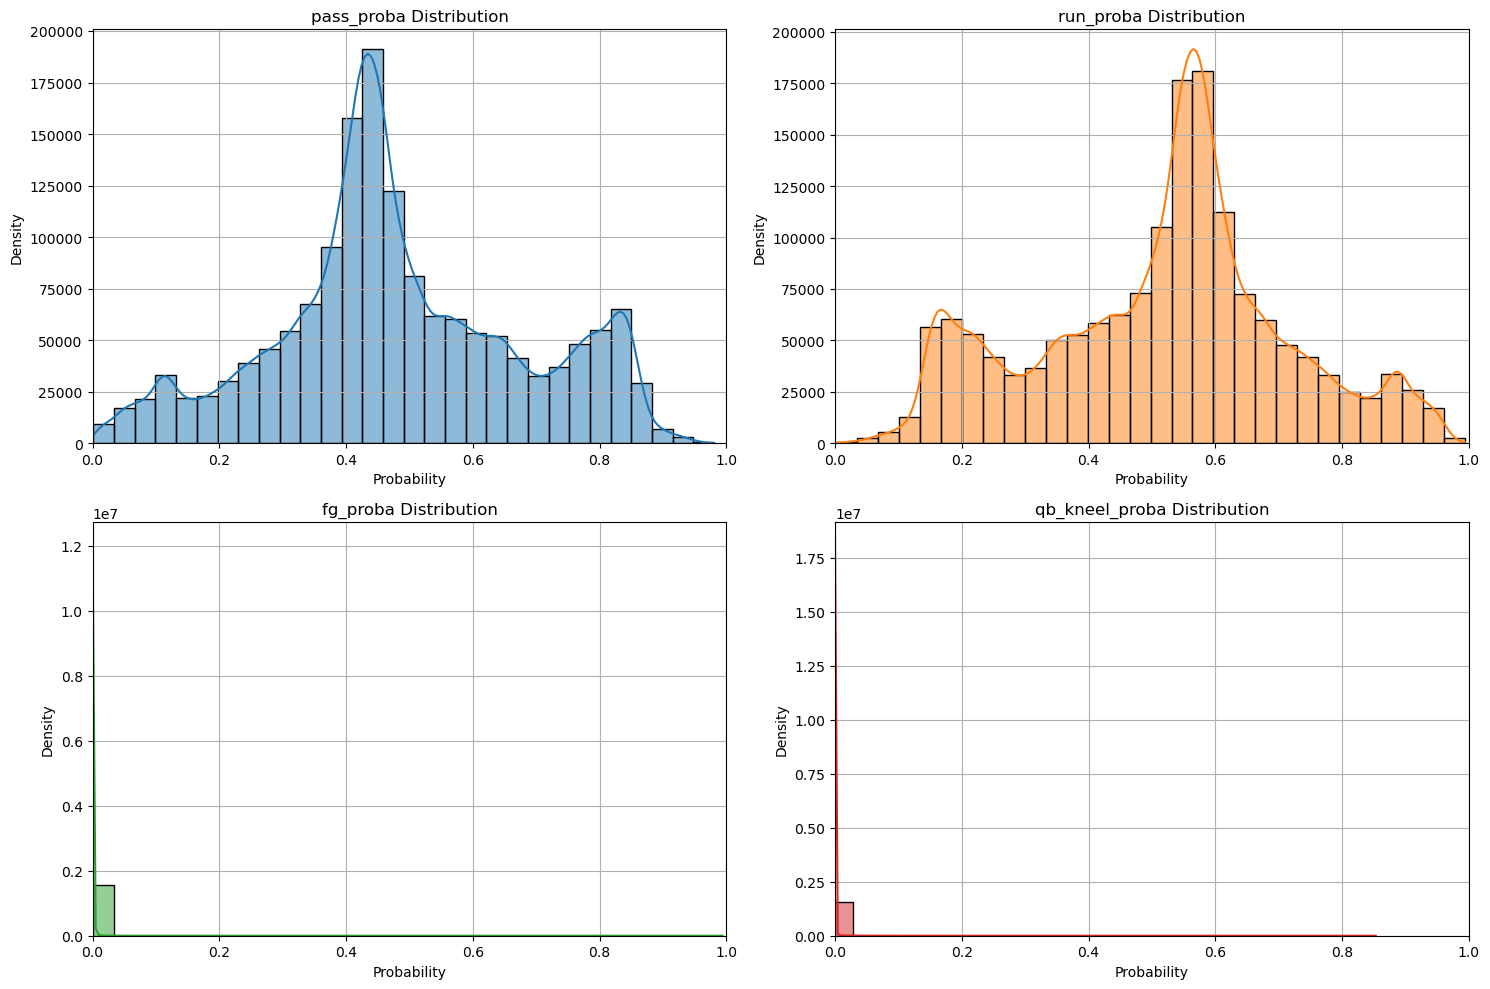

In [48]:
def plot_multiclass_probas(df, proba_cols=['pass_proba', 'run_proba', 'fg_proba', 'qb_kneel_proba']):
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(proba_cols, 1):
        plt.subplot(2, 2, i)  # 2x2 grid of plots
        sns.histplot(df[col], bins=30, kde=True, color=f'C{i-1}')
        plt.title(f'{col} Distribution')
        plt.xlabel('Probability')
        plt.ylabel('Density')
        plt.grid(True)
        plt.xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

plot_multiclass_probas(decisions)

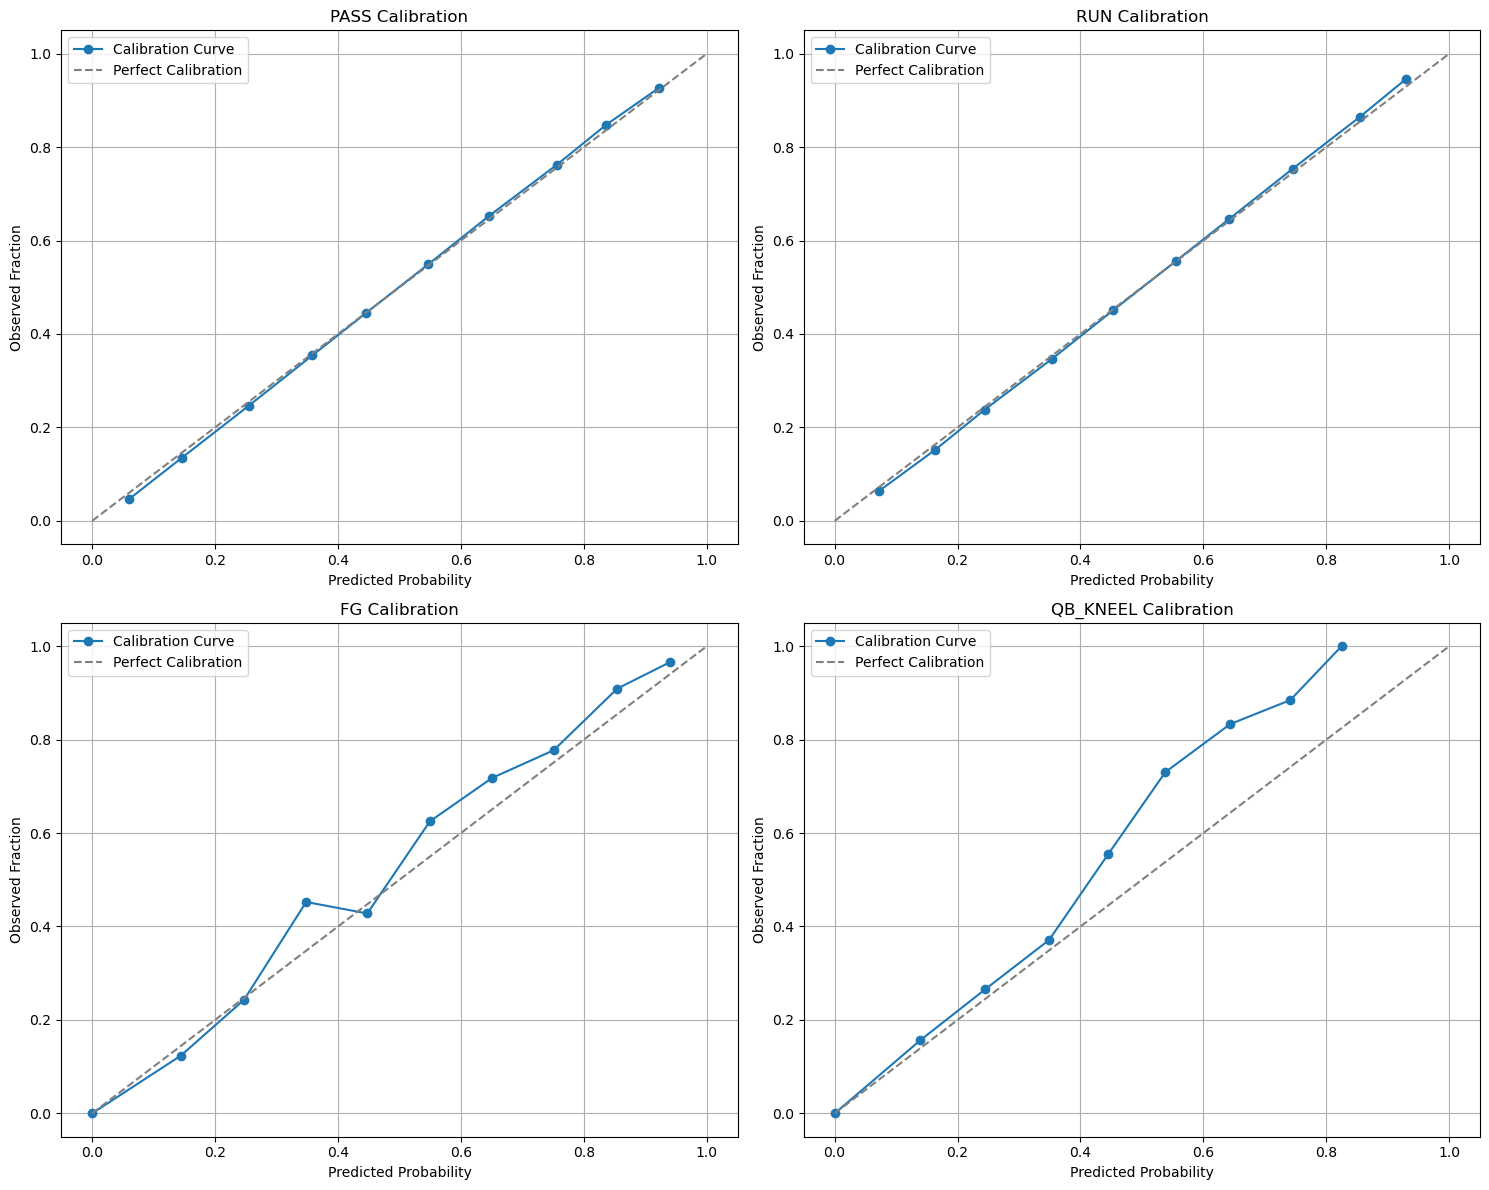

In [52]:
def plot_multiclass_calibration(df, proba_cols, actual_cols, bins=30):
    """
    Plots calibration curves for multiple classes in subplots.
    
    Args:
        df: DataFrame containing predicted probabilities and actual outcomes
        proba_cols: List of predicted probability columns (e.g., ['pass_proba', 'run_proba', ...])
        actual_cols: List of actual outcome columns (should be binary 0/1 for each class)
        bins: Number of bins for calibration
    """
    plt.figure(figsize=(15, 12))
    
    for i, (proba_col, actual_col) in enumerate(zip(proba_cols, actual_cols), 1):
        plt.subplot(2, 2, i)
        
        df['proba_bin'] = pd.cut(df[proba_col], 
                                bins=np.linspace(0, 1, bins + 1),
                                labels=False, 
                                include_lowest=True)
        
        calibration = df.groupby('proba_bin').agg(
            predicted_proba=(proba_col, 'mean'),
            actual_proba=(actual_col, 'mean'),
            count=(proba_col, 'size')
        ).reset_index()
        
        plt.plot(calibration['predicted_proba'], calibration['actual_proba'], 
                'o-', label='Calibration Curve')
        plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
        
        plt.title(f'{proba_col.replace("_proba", "").upper()} Calibration')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Observed Fraction')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_multiclass_calibration(
    df=decisions,
    proba_cols=['pass_proba', 'run_proba', 'fg_proba', 'qb_kneel_proba'],
    actual_cols=['was_pass', 'was_run', 'was_field_goal', 'was_kneel'],
    bins=10
)